In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geojsonio
from datetime import timedelta, date, datetime
import time
import plotly.express as px
import glob as gb
import json
import pytz

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE+2)  # fontsize of the figure title

# Data Exploration

In [3]:
#Sample of format of each line as read from the input file
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internet']
read_data = pd.read_csv('dataverse_files/sms-call-internet-mi-2013-11-01.txt' ,sep='\t',header=None, names=col_list, \
                        parse_dates=True)

In [4]:
read_data.head(10)

,gridID,timeInterval,countryCode,smsIn,smsOut,callIn,callOut,internet
0,1,1383260400000,0,0.081363,NaN,NaN,NaN,NaN
1,1,1383260400000,39,0.141864,0.156787,0.160938,0.052275,11.028366
2,1,1383261000000,0,0.136588,NaN,NaN,0.027300,NaN
3,1,1383261000000,33,NaN,NaN,NaN,NaN,0.026137
4,1,1383261000000,39,0.278452,0.119926,0.188777,0.133637,11.100963
5,1,1383261600000,0,0.053438,NaN,NaN,NaN,NaN
6,1,1383261600000,39,0.330641,0.170952,0.134176,0.054601,10.892771
7,1,1383262200000,0,0.026137,NaN,NaN,NaN,NaN
8,1,1383262200000,39,0.681434,0.220815,0.027300,0.053438,8.622425
9,1,1383262800000,0,0.027300,NaN,NaN,NaN,NaN


In [5]:
start_time = time.time()

#Initialize an empty dataframe to append daily and hourly resampled data
dailyGridActivity = pd.DataFrame()
hourlyGridActivity = pd.DataFrame()

#Create a list of 62 data file names placed under directory  "dataverse_files" with extension .txt
filenames = gb.glob("dataverse_files/*.txt")

#Set the column names for the data read
col_list = ['gridID', 'timeInterval', 'countryCode', 'smsIn', 'smsOut', 'callIn', 'callOut', 'internet']

#Read each tab separated file into Pandas DataFrame 
for file in filenames:
    read_data = pd.read_csv(file, sep='\t',header=None, names=col_list, parse_dates=True)
    
    #Convert timeInterval column which has Epoch timestamps to UTC and then convert to Milan's local timezone
    read_data['startTime'] = pd.to_datetime(read_data.timeInterval, unit='ms', utc=True).dt.tz_convert('CET').dt.tz_localize(None)
    
    #Drop timeInterval & countryCode columns
    read_data.drop(columns=['timeInterval','countryCode'], inplace=True)
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to daily aggregation 
    read_data_daily = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='D')]).sum()
    dailyGridActivity = pd.concat([dailyGridActivity,read_data_daily]).groupby(['gridID', 'startTime']).sum()
    
    #Groupby gridID and startTime, startTime which is 10 min apart is resampled to hourly aggregation 
    read_data_hourly = read_data.groupby(['gridID', pd.Grouper(key='startTime', freq='H')]).sum()
    hourlyGridActivity = pd.concat([hourlyGridActivity,read_data_hourly]).groupby(['gridID', 'startTime']).sum()
    
#Get Grid wise total volume of the activities over the 2months
totalGridActivity = dailyGridActivity.groupby('gridID').sum()
    
print('%3.2f s' %(time.time() - start_time))

920.23 s


In [6]:
hourlyGridActivity.head(5000)

smsIn    smsOut    callIn   callOut   internet
gridID startTime                                                             
1      2013-11-01 00:00:00  2.084285  1.104749  0.591930  0.429290  57.799009
       2013-11-01 01:00:00  1.163624  0.770031  0.190564  0.194139  44.046899
       2013-11-01 02:00:00  0.415579  0.300391  0.027925  0.135964  41.207149
       2013-11-01 03:00:00  1.152067  0.895724  0.001787  0.026137  33.022070
       2013-11-01 04:00:00  0.354453  0.511192  0.005362  0.026137  31.376930
...                              ...       ...       ...       ...        ...
4      2013-11-23 03:00:00  0.099817  2.037928  0.004295  0.167640  36.829311
       2013-11-23 04:00:00  0.257734  0.106141  0.000000  0.054601  36.292167
       2013-11-23 05:00:00  0.103714  0.100315  0.054601  0.076811  34.064567
       2013-11-23 06:00:00  0.108009  0.306172  0.108407  0.244849  39.800249
       2013-11-23 07:00:00  1.182191  0.616518  0.442614  0.625067  47.390257

[5000 rows x 5 columns]

In [7]:
dailyGridActivity.head(500)

smsIn     smsOut     callIn    callOut     internet
gridID startTime                                                           
1      2013-11-01   78.709755  45.886570  41.108567  48.245378  1507.048349
       2013-11-02   86.415810  43.875946  47.891016  53.590637  1515.641856
       2013-11-03   77.728292  45.446780  36.145436  40.906425  1533.148425
       2013-11-04  104.793806  54.821018  67.898464  70.399418  1404.813593
       2013-11-05   97.425105  46.607029  68.735213  70.766221  1518.090111
...                       ...        ...        ...        ...          ...
8      2014-01-01  130.517503  99.275988  44.301193  56.217203  1543.200551
9      2013-11-01   81.055914  47.112892  42.416108  50.085915  1519.045771
       2013-11-02   89.146546  45.189190  49.429735  55.512801  1530.270726
       2013-11-03   79.818308  46.344805  37.319172  42.306906  1546.944682
       2013-11-04  108.445224  56.559079  70.004163  72.707383  1417.651191

[500 rows x 5 columns]

In [8]:
totalGridActivity.head(100)

,smsIn,smsOut,callIn,callOut,internet
gridID,,,,,
1,6178.894730,3358.842325,3805.892719,3991.422048,92992.666580
2,6267.021008,3402.658923,3861.301592,4052.842143,93368.388389
3,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391
4,5923.635378,3231.926757,3645.399918,3813.517635,91904.381588
5,5522.707656,3017.566898,3401.745307,3568.366951,83630.697355
...,...,...,...,...,...
96,5416.773619,2129.289770,4479.519197,6193.988256,120997.581760
97,5416.773619,2129.289770,4479.519197,6193.988256,120997.581760
98,5417.533255,2131.471698,4483.270280,6196.464512,121044.447743


In [9]:
#Create additional columns hours:hour of the day, weekdayFlag: weekend or weekday information
dailyGridActivity['weekdayFlag'] = dailyGridActivity.index.get_level_values(1)
dailyGridActivity['weekdayFlag'] = dailyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['weekdayFlag'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['weekdayFlag'] = hourlyGridActivity['weekdayFlag'].dt.weekday

hourlyGridActivity['hours'] = hourlyGridActivity.index.get_level_values(1)
hourlyGridActivity['hours'] = hourlyGridActivity['hours'].dt.hour

dailyGridActivity['sms'] = dailyGridActivity['smsIn'] + dailyGridActivity['smsOut']
dailyGridActivity['call'] = dailyGridActivity['callIn'] + dailyGridActivity['callOut']

hourlyGridActivity['sms'] = hourlyGridActivity['smsIn'] + hourlyGridActivity['smsOut']
hourlyGridActivity['call'] = hourlyGridActivity['callIn'] + hourlyGridActivity['callOut']

totalGridActivity['sms'] = totalGridActivity['smsIn']+totalGridActivity['smsOut']
totalGridActivity['call'] = totalGridActivity['callIn']+totalGridActivity['callOut']

In [10]:
dailyGridActivity.head()

smsIn     smsOut     callIn    callOut     internet  \
gridID startTime                                                              
1      2013-11-01   78.709755  45.886570  41.108567  48.245378  1507.048349   
       2013-11-02   86.415810  43.875946  47.891016  53.590637  1515.641856   
       2013-11-03   77.728292  45.446780  36.145436  40.906425  1533.148425   
       2013-11-04  104.793806  54.821018  67.898464  70.399418  1404.813593   
       2013-11-05   97.425105  46.607029  68.735213  70.766221  1518.090111   

                   weekdayFlag         sms        call  
gridID startTime                                        
1      2013-11-01            4  124.596325   89.353945  
       2013-11-02            5  130.291756  101.481653  
       2013-11-03            6  123.175072   77.051861  
       2013-11-04            0  159.614824  138.297882  
       2013-11-05            1  144.032134  139.501434

In [11]:
hourlyGridActivity.head()

smsIn    smsOut    callIn   callOut   internet  \
gridID startTime                                                                
1      2013-11-01 00:00:00  2.084285  1.104749  0.591930  0.429290  57.799009   
       2013-11-01 01:00:00  1.163624  0.770031  0.190564  0.194139  44.046899   
       2013-11-01 02:00:00  0.415579  0.300391  0.027925  0.135964  41.207149   
       2013-11-01 03:00:00  1.152067  0.895724  0.001787  0.026137  33.022070   
       2013-11-01 04:00:00  0.354453  0.511192  0.005362  0.026137  31.376930   

                            weekdayFlag  hours       sms      call  
gridID startTime                                                    
1      2013-11-01 00:00:00            4      0  3.189034  1.021221  
       2013-11-01 01:00:00            4      1  1.933655  0.384704  
       2013-11-01 02:00:00            4      2  0.715969  0.163888  
       2013-11-01 03:00:00            4      3  2.047791  0.027925  
       2013-11-01 04:00:00            4      4  0.865645  0.031499

In [12]:
totalGridActivity.head()

,smsIn,smsOut,callIn,callOut,internet,sms,call
gridID,,,,,,,
1,6178.894730,3358.842325,3805.892719,3991.422048,92992.666580,9537.737054,7797.314767
2,6267.021008,3402.658923,3861.301592,4052.842143,93368.388389,9669.679931,7914.143735
3,6360.827944,3449.299959,3920.282146,4118.221405,93768.329391,9810.127903,8038.503551
4,5923.635378,3231.926757,3645.399918,3813.517635,91904.381588,9155.562135,7458.917553
5,5522.707656,3017.566898,3401.745307,3568.366951,83630.697355,8540.274554,6970.112258


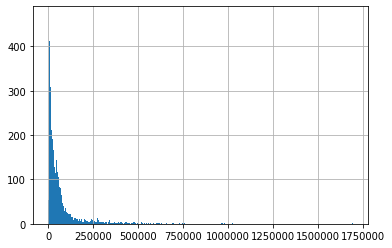

In [13]:
hist = totalGridActivity['sms'].hist(bins=1000)

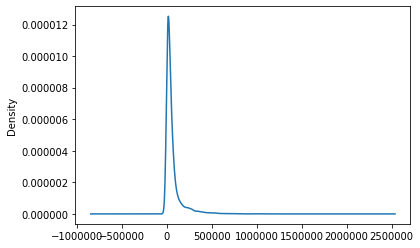

In [14]:
hist = totalGridActivity['sms'].plot.kde()

## Test the plot with matplotlib

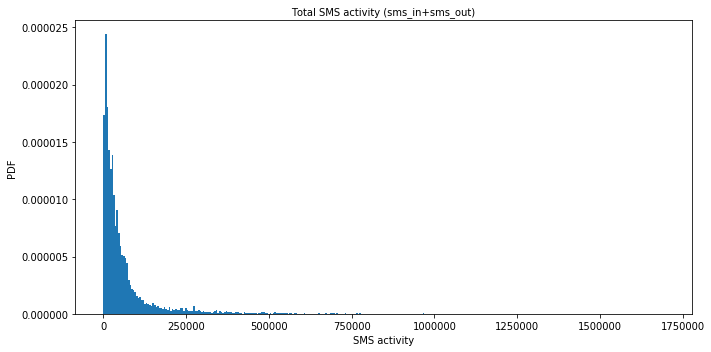

In [15]:
plt.figure(figsize=(10,5))
plt.hist(totalGridActivity['sms'], bins='auto', density=True)
plt.xlabel('SMS activity')
plt.ylabel('PDF')
plt.title(r'Total SMS activity (sms_in+sms_out)')
plt.tight_layout()
plt.savefig('sav_images/totalsms.svg',transparent=True)
plt.show()

## Seaborn provides combined kde and histogram plot

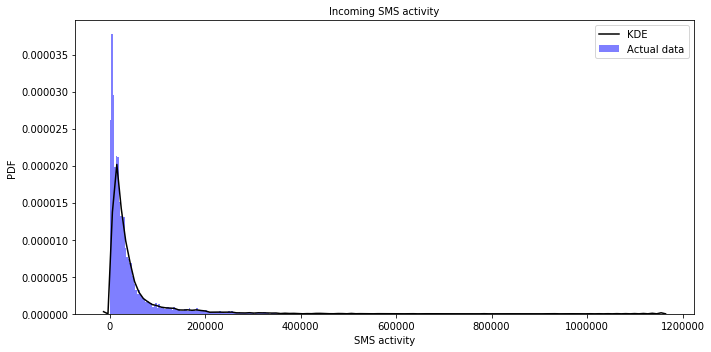

In [16]:
plt.figure(figsize=(10,5))
ax = sns.distplot(totalGridActivity['smsIn'], bins='auto', kde=True, \
                  norm_hist=True, kde_kws={'color':'k','label':'KDE'}, \
                  hist_kws={'color':'blue','alpha':0.5,'label':'Actual data'})
plt.xlabel('SMS activity')
plt.ylabel('PDF')
plt.title(r'Incoming SMS activity')
plt.tight_layout()
plt.savefig('sav_images/sms_in_kde.svg',transparent=True)
plt.show()

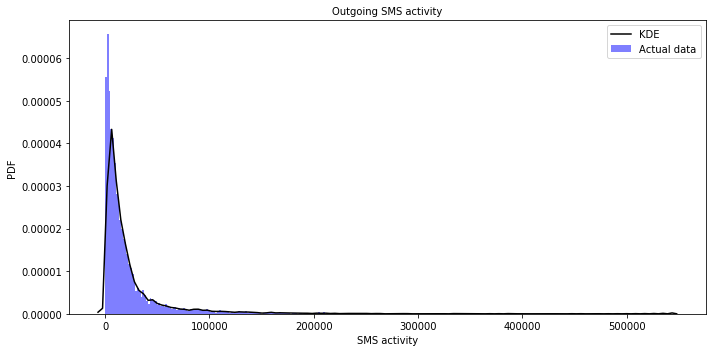

In [17]:
plt.figure(figsize=(10,5))
ax = sns.distplot(totalGridActivity['smsOut'], bins='auto', kde=True, \
                  norm_hist=True, kde_kws={'color':'k','label':'KDE'}, \
                  hist_kws={'color':'blue','alpha':0.5,'label':'Actual data'})
plt.xlabel('SMS activity')
plt.ylabel('PDF')
plt.title(r'Outgoing SMS activity')
plt.tight_layout()
plt.savefig('sav_images/sms_out_kde.svg',transparent=True)
plt.show()

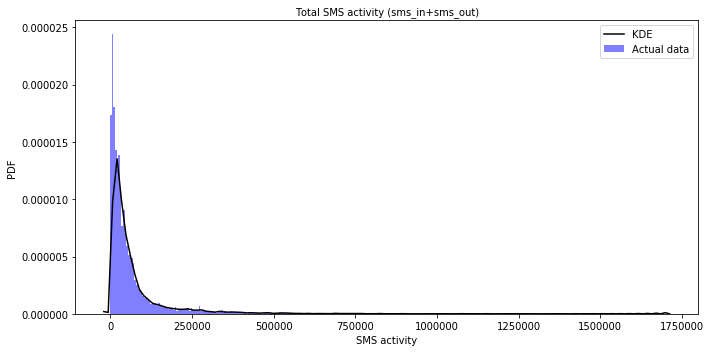

In [18]:
plt.figure(figsize=(10,5))
ax = sns.distplot(totalGridActivity['sms'], bins='auto', kde=True, \
                  norm_hist=True, kde_kws={'color':'k','label':'KDE'}, \
                  hist_kws={'color':'blue','alpha':0.5,'label':'Actual data'})
plt.xlabel('SMS activity')
plt.ylabel('PDF')
plt.title(r'Total SMS activity (sms_in+sms_out)')
plt.tight_layout()
plt.savefig('sav_images/sms_total_kde.svg',transparent=True)
plt.show()

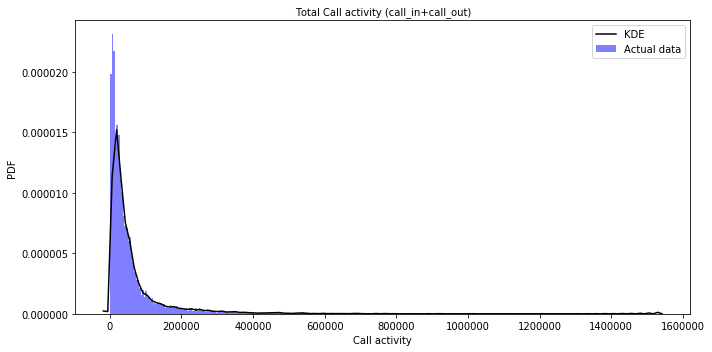

In [19]:
plt.figure(figsize=(10,5))
ax = sns.distplot(totalGridActivity['call'], bins='auto', kde=True, \
                  norm_hist=True, kde_kws={'color':'k','label':'KDE'}, \
                  hist_kws={'color':'blue','alpha':0.5,'label':'Actual data'})
plt.xlabel('Call activity')
plt.ylabel('PDF')
plt.title(r'Total Call activity (call_in+call_out)')
plt.tight_layout()
plt.savefig('sav_images/call_total_kde.svg',transparent=True)
plt.show()

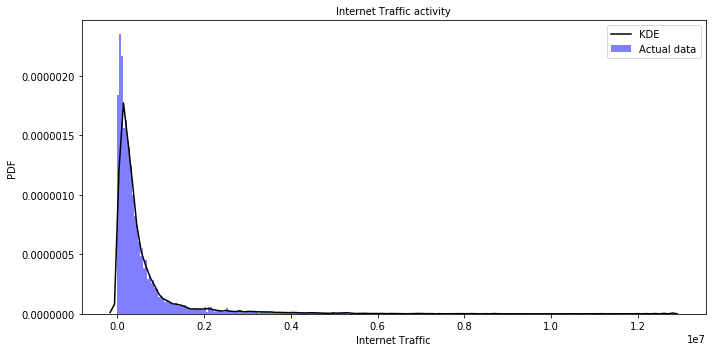

In [20]:
plt.figure(figsize=(10,5))
ax = sns.distplot(totalGridActivity['internet'], bins='auto', kde=True, \
                  norm_hist=True, kde_kws={'color':'k','label':'KDE'}, \
                  hist_kws={'color':'blue','alpha':0.5,'label':'Actual data'})
plt.xlabel('Internet Traffic')
plt.ylabel('PDF')
plt.title(r'Internet Traffic activity')
plt.tight_layout()
plt.savefig('sav_images/internet_kde.svg',transparent=True)
plt.show()

## Top 10 grids

In [21]:
smsInGridActivity = totalGridActivity[['smsIn']].sort_values(by = 'smsIn',ascending=False)
smsOutGridActivity = totalGridActivity[['smsOut']].sort_values(by = 'smsOut',ascending=False)
callInGridActivity = totalGridActivity[['callIn']].sort_values(by = 'callIn',ascending=False)
callOutGridActivity = totalGridActivity[['callOut']].sort_values(by = 'callOut',ascending=False)

smsGridActivity = totalGridActivity[['sms']].sort_values(by = 'sms',ascending=False)
callGridActivity = totalGridActivity[['call']].sort_values(by = 'call',ascending=False)
internetGridActivity = totalGridActivity[['internet']].sort_values(by = 'internet',ascending=False)

#Fetch the top 10 grids from the sorted grids and display them
top10 = pd.DataFrame()
top10['smsIn'] = smsInGridActivity[:10].index.values
top10['smsOut'] = smsOutGridActivity[:10].index.values
top10['callIn'] = callInGridActivity[:10].index.values
top10['callOut'] = callOutGridActivity[:10].index.values
top10['sms'] = smsGridActivity[:10].index.values
top10['call'] = callGridActivity[:10].index.values
top10['internet'] = internetGridActivity[:10].index.values

In [22]:
top10

,smsIn,smsOut,callIn,callOut,sms,call,internet
0,5059,5059,5059,5059,5059,5059,5161
1,5161,4855,5161,6064,5161,6064,5059
2,6064,4856,6064,5161,6064,5161,5259
3,5061,5061,5159,5159,5061,5159,5061
4,5159,5259,5259,6165,5159,5061,5258
5,5262,4874,5061,5061,5259,5259,5159
6,5259,5161,5262,6058,5262,6165,6064
7,5162,5159,6058,5259,4855,5262,4855
8,6165,5262,6165,5262,4856,6058,4856
9,6058,6064,5162,5256,6165,5162,5262


* For the internet traffic, the area with the highest total traffic during the two-month period: 5161
* For the smsin, smsout, total sms activity, the area with the highest total traffic during the two-month period: 5059
* For the callin, callout, total call activity, the area with the highest total traffic during the two-month period: 5059

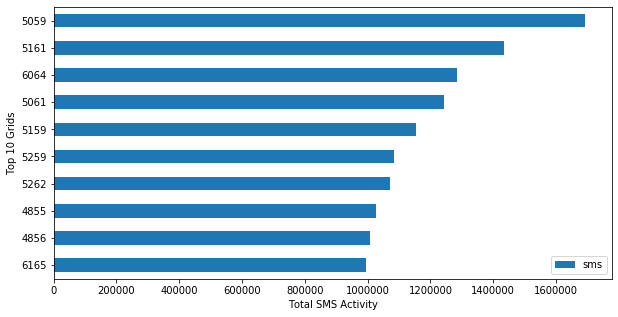

In [23]:
#Plot top 10 grids and its volume for SMS activity
ax = smsGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("Total SMS Activity")
ax.set_ylabel("Top 10 Grids")
fig = ax.get_figure()
fig.savefig('sav_images/sms_top10.svg',transparent=True)

In [24]:
#Token for Mapbox API

token = r'pk.eyJ1IjoicGpzdWRoYXJzaGFuIiwiYSI6ImNrY295YTZ4aTBwczEydHF5aG1qM2M4NTMifQ.8MXIaUGorClC0Z4SG9NduQ'

In [25]:
#Read GeoJSON file
milan = gpd.read_file('milano-grid.geojson')

In [ ]:
#Visualize the region of interest on map

fig = px.choropleth_mapbox(smsGridActivity[:10].reset_index(),
                           geojson=milan,
                           locations='gridID',
                           color='sms',
                           zoom=12.3, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/sms_top10_visual.svg')
fig.show()

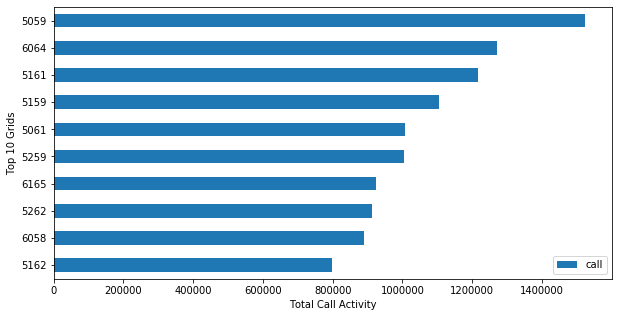

In [26]:
#Plot top 10 grids and its volume for Call activity
ax = callGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("Total Call Activity")
ax.set_ylabel("Top 10 Grids")
fig = ax.get_figure()
fig.savefig('sav_images/call_top10.svg',transparent=True)

In [ ]:
#Visualize the region of interest on map

fig = px.choropleth_mapbox(callGridActivity[:10].reset_index(),
                           geojson=milan,
                           locations='gridID',
                           color='call',
                           zoom=12.3, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/call_top10_visual.svg')
fig.show()

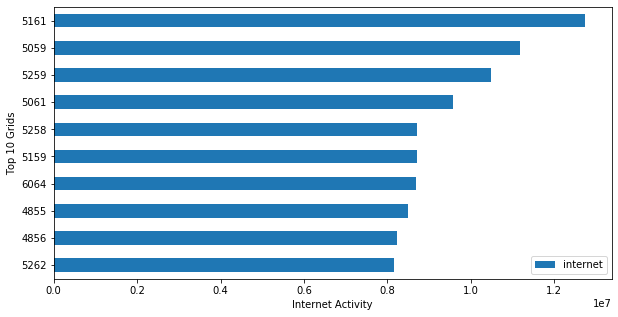

In [27]:
#Plot top 10 grids and its volume for Internet activity
ax = internetGridActivity[:10].plot(kind='barh', figsize=(10,5))
ax.invert_yaxis()
ax.set_xlabel("Internet Activity")
ax.set_ylabel("Top 10 Grids")
fig = ax.get_figure()
fig.savefig('sav_images/internet_top10.svg',transparent=True)

In [ ]:
#Visualize the region of interest on map

fig = px.choropleth_mapbox(internetGridActivity[:10].reset_index(),
                           geojson=milan,
                           locations='gridID',
                           color='internet',
                           zoom=12.3, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/internet_top10_visual.svg')
fig.show()

## Visualization of SMS, Call and Internet activities

### Doesn't display well

In [28]:
#get unique values across all the columns in dataframe top10
topgrids = pd.unique(top10.values.ravel())

In [ ]:
#New browser opens with the top 10 grids
topGridgeojson = milan.loc[milan['cellId'].isin(topgrids)]
topGridgeojson = topGridgeojson.to_json()

#Uncomment below line to display on browser
# _ = geojsonio.display(topGridgeojson)

### Change to Plotly library - which can provide better visualiztion

In [ ]:
#Internet Activity Visualization

internetGridActivity_rest = internetGridActivity.reset_index()
internetGridActivity_min = internetGridActivity_rest['internet'].min()
internetGridActivity_max = internetGridActivity_rest['internet'].max()

fig = px.choropleth_mapbox(internetGridActivity_rest, geojson=milan, locations='gridID', color='internet',
                           color_continuous_scale="thermal",
                           range_color=(internetGridActivity_min, internetGridActivity_max),
                           zoom=10.5, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7,
                           labels={'internet':'Internet Traffic'}
                          )
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/internet_visual.svg')
fig.show()

In [ ]:
#Call Activity Visualization

callGridActivity_rest = callGridActivity.reset_index()
callGridActivity_min = callGridActivity_rest['call'].min()
callGridActivity_max = callGridActivity_rest['call'].max()

fig = px.choropleth_mapbox(callGridActivity_rest, geojson=milan, locations='gridID', color='call',
                           color_continuous_scale="thermal",
                           range_color=(callGridActivity_min, callGridActivity_max),
                           zoom=10.5, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7,
                           labels={'call':'Call Activity'}
                          )
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/call_visual.svg')
fig.show()

In [ ]:
#SMS Activity Visualization

smsGridActivity_rest = smsGridActivity.reset_index()
smsGridActivity_min = smsGridActivity_rest['sms'].min()
smsGridActivity_max = smsGridActivity_rest['sms'].max()

fig = px.choropleth_mapbox(smsGridActivity_rest, geojson=milan, locations='gridID', color='sms',
                           color_continuous_scale="thermal",
                           range_color=(smsGridActivity_min, smsGridActivity_max),
                           zoom=10.5, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7,
                           labels={'sms':'SMS Activity'}
                          )
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/sms_visual.svg')
fig.show()

## Three regions of interest - Square id 5161 (Top internet activity), 4159 and 4556

### Daily Analysis

In [29]:
#Three regions of interest
sqid_intr = ['5161','4159','4556']
daily5161 = dailyGridActivity.loc[5161][['sms','call','internet']]
daily4159 = dailyGridActivity.loc[4159][['sms','call','internet']]
daily4556 = dailyGridActivity.loc[4556][['sms','call','internet']]

In [30]:
#We are interested only in first two weeks
days_intr = 14
start_date = date(2013, 11, 1)
end_date = start_date + timedelta(days_intr-1)

daily5161_intr = daily5161.loc[start_date:end_date]
daily4159_intr = daily4159.loc[start_date:end_date]
daily4556_intr = daily4556.loc[start_date:end_date]

sqid_daily_intr = [daily5161_intr, daily4159_intr, daily4556_intr]

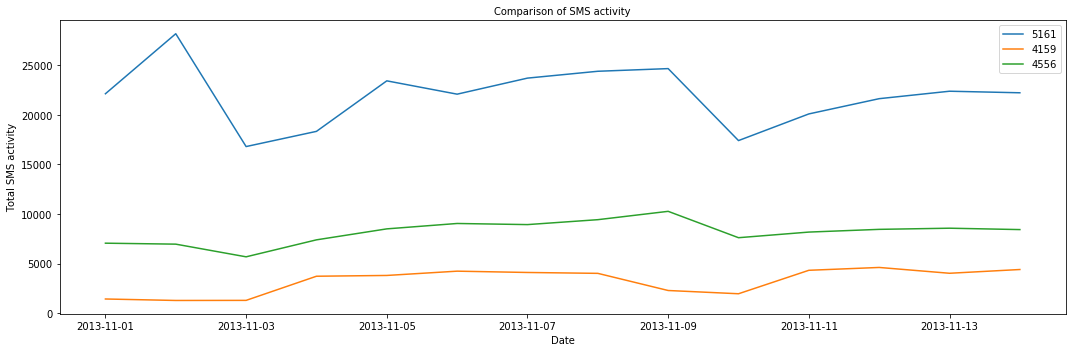

In [31]:
plt.figure(figsize=(15,5))
for i,sqid in enumerate(sqid_daily_intr):
    plt.plot(sqid.index, sqid.sms, label=sqid_intr[i])
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total SMS activity')
plt.title('Comparison of SMS activity')
plt.tight_layout()
plt.savefig('sav_images/sms_timeseries.svg',transparent=True)
plt.show()

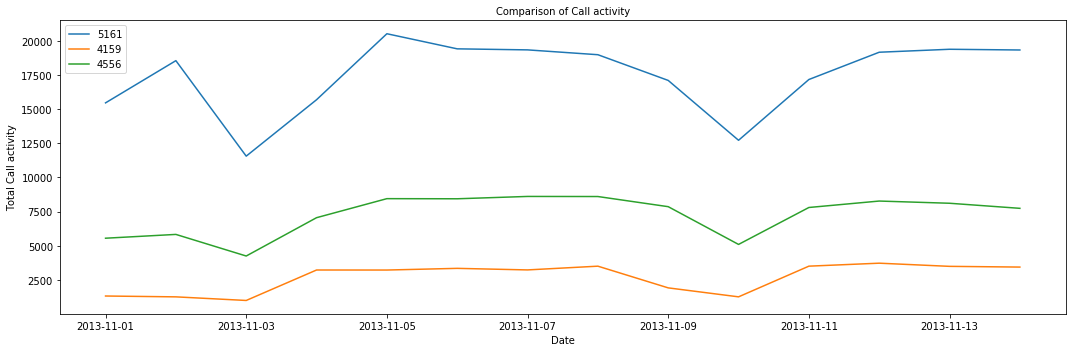

In [32]:
plt.figure(figsize=(15,5))
for i,sqid in enumerate(sqid_daily_intr):
    plt.plot(sqid.index, sqid.call, label=sqid_intr[i])
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Call activity')
plt.title('Comparison of Call activity')
plt.tight_layout()
plt.savefig('sav_images/call_timeseries.svg',transparent=True)
plt.show()

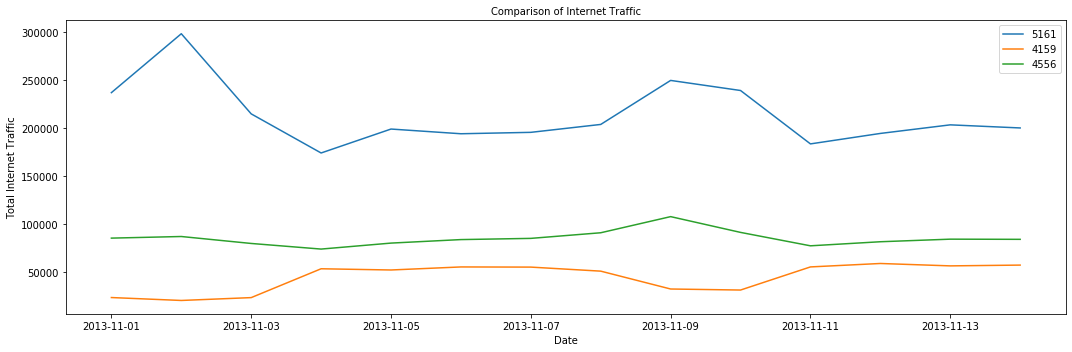

In [33]:
plt.figure(figsize=(15,5))
for i,sqid in enumerate(sqid_daily_intr):
    plt.plot(sqid.index, sqid.internet, label=sqid_intr[i])
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Total Internet Traffic')
plt.title('Comparison of Internet Traffic')
plt.tight_layout()
plt.savefig('sav_images/internet_timeseries.svg',transparent=True)
plt.show()

In [ ]:
#Visualize the region of interest on map

fig = px.choropleth_mapbox(pd.DataFrame(sqid_intr, columns=['sqid']),
                           geojson=milan,
                           locations='sqid',
                           color='sqid',
                           zoom=12, center = {"lat": 45.4646, "lon": 9.1885},
                           opacity=0.7)
fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image('sav_images/sqid_intr_visual.svg')
fig.show()

### Hourly Analysis

In [34]:
pd.options.mode.chained_assignment = None

#Get hourly data for the three grids 
hourly5161 = hourlyGridActivity.loc[5161]
hourly4159 = hourlyGridActivity.loc[4159]
hourly4556 = hourlyGridActivity.loc[4556]

#We are interested only in first two weeks
hourly5161_intr = hourly5161.loc[start_date:end_date]
hourly4159_intr = hourly4159.loc[start_date:end_date]
hourly4556_intr = hourly4556.loc[start_date:end_date]

#Add column to identify Day of the week for each observation
hourly5161_intr['dayOfWeek'] = hourly5161_intr.index.day_name()
hourly4159_intr['dayOfWeek'] = hourly4159_intr.index.day_name()
hourly4556_intr['dayOfWeek'] = hourly4556_intr.index.day_name()

#Use pivot_table() reshape the dataframe with Mean values of the acitivities for Day of the week as columns and hours in a day as index
hourly5161_sms_intr = hourly5161_intr.pivot_table(index=hourly5161_intr.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly5161_call_intr = hourly5161_intr.pivot_table(index=hourly5161_intr.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly5161_internet_intr = hourly5161_intr.pivot_table(index=hourly5161_intr.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')

hourly4159_sms_intr = hourly4159_intr.pivot_table(index=hourly4159_intr.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly4159_call_intr = hourly4159_intr.pivot_table(index=hourly4159_intr.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly4159_internet_intr = hourly4159_intr.pivot_table(index=hourly4159_intr.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')

hourly4556_sms_intr = hourly4556_intr.pivot_table(index=hourly4556_intr.index.hour,
                                                            columns='dayOfWeek', values='sms', aggfunc='mean')
hourly4556_call_intr = hourly4556_intr.pivot_table(index=hourly4556_intr.index.hour,
                                                            columns='dayOfWeek', values='call', aggfunc='mean')
hourly4556_internet_intr = hourly4556_intr.pivot_table(index=hourly4556_intr.index.hour,
                                                            columns='dayOfWeek', values='internet', aggfunc='mean')

In [35]:
hourly5161_sms_intr = hourly5161_sms_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4159_sms_intr = hourly4159_sms_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4556_sms_intr = hourly4556_sms_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]

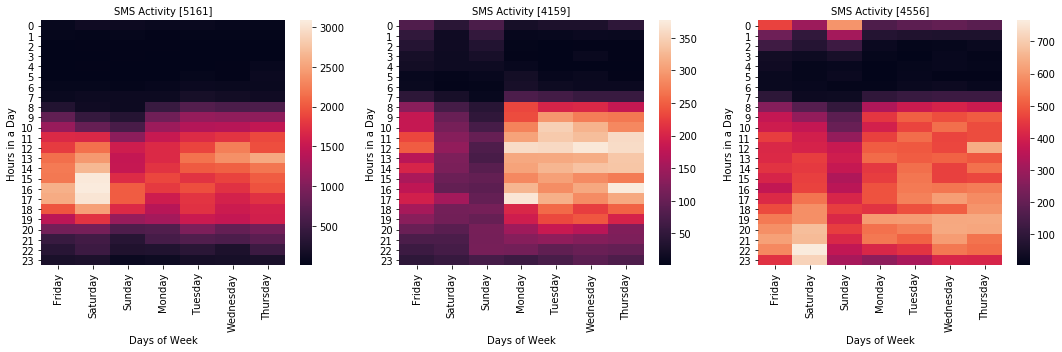

In [36]:
#From the reshaped dataframe plot heatmap for SMS activity of the three grids

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title("SMS Activity [5161]")
ax[1].set_title("SMS Activity [4159]")
ax[2].set_title("SMS Activity [4556]")

sns.heatmap(hourly5161_sms_intr, ax=ax[0])
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")
sns.heatmap(hourly4159_sms_intr, ax=ax[1])
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")
sns.heatmap(hourly4556_sms_intr, ax=ax[2])
ax[2].set_ylabel("Hours in a Day")
ax[2].set_xlabel("Days of Week")
fig.tight_layout()
plt.savefig('sav_images/sms_hourly.svg',transparent=True)
plt.show()

In [37]:
hourly5161_call_intr = hourly5161_call_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4159_call_intr = hourly4159_call_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4556_call_intr = hourly4556_call_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]

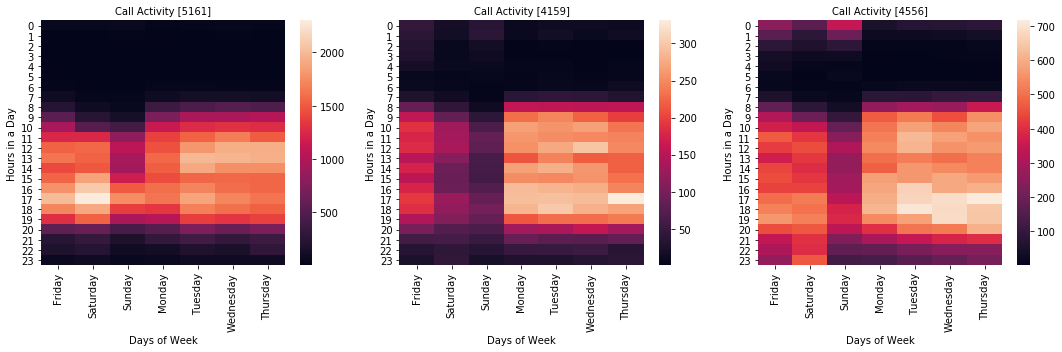

In [38]:
#From the reshaped dataframe plot heatmap for Call activity of the three grids

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title("Call Activity [5161]")
ax[1].set_title("Call Activity [4159]")
ax[2].set_title("Call Activity [4556]")

sns.heatmap(hourly5161_call_intr, ax=ax[0])
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")
sns.heatmap(hourly4159_call_intr, ax=ax[1])
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")
sns.heatmap(hourly4556_call_intr, ax=ax[2])
ax[2].set_ylabel("Hours in a Day")
ax[2].set_xlabel("Days of Week")
fig.tight_layout()
plt.savefig('sav_images/call_hourly.svg',transparent=True)
plt.show()

In [39]:
hourly5161_internet_intr = hourly5161_internet_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4159_internet_intr = hourly4159_internet_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]
hourly4556_internet_intr = hourly4556_internet_intr[['Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday']]

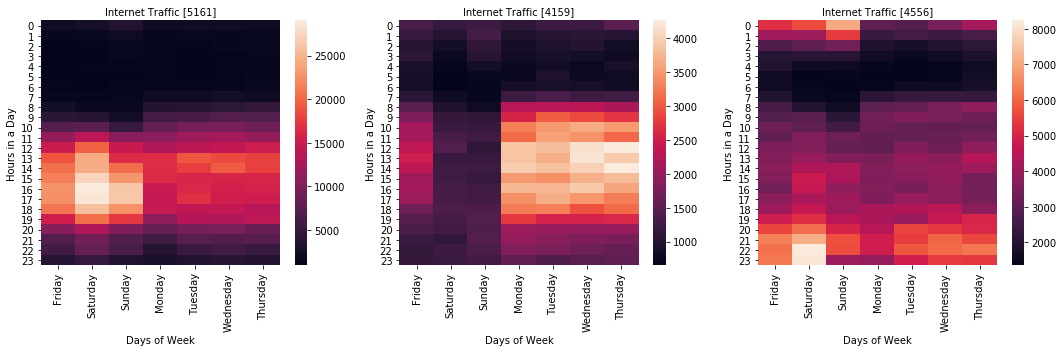

In [40]:
#From the reshaped dataframe plot heatmap for internet traffic of the three grids

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title("Internet Traffic [5161]")
ax[1].set_title("Internet Traffic [4159]")
ax[2].set_title("Internet Traffic [4556]")

sns.heatmap(hourly5161_internet_intr, ax=ax[0])
ax[0].set_ylabel("Hours in a Day")
ax[0].set_xlabel("Days of Week")
sns.heatmap(hourly4159_internet_intr, ax=ax[1])
ax[1].set_ylabel("Hours in a Day")
ax[1].set_xlabel("Days of Week")
sns.heatmap(hourly4556_internet_intr, ax=ax[2])
ax[2].set_ylabel("Hours in a Day")
ax[2].set_xlabel("Days of Week")
fig.tight_layout()
plt.savefig('sav_images/internet_hourly.svg',transparent=True)
plt.show()

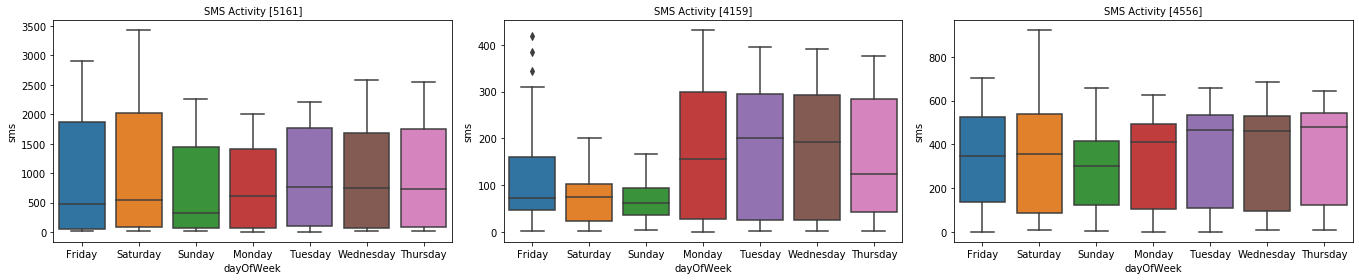

In [41]:
#Plot box plot of SMS activity for each day of the week

fig, ax = plt.subplots(1,3,figsize=(19,4))
ax[0].set_title("SMS Activity [5161]")
ax[1].set_title("SMS Activity [4159]")
ax[2].set_title("SMS Activity [4556]")

sns.boxplot(hourly5161_intr['dayOfWeek'], hourly5161_intr['sms'], ax=ax[0])
sns.boxplot(hourly4159_intr['dayOfWeek'], hourly4159_intr['sms'], ax=ax[1])
sns.boxplot(hourly4556_intr['dayOfWeek'], hourly4556_intr['sms'], ax=ax[2])
fig.tight_layout()
plt.savefig('sav_images/sms_daily.svg',transparent=True)
plt.show()

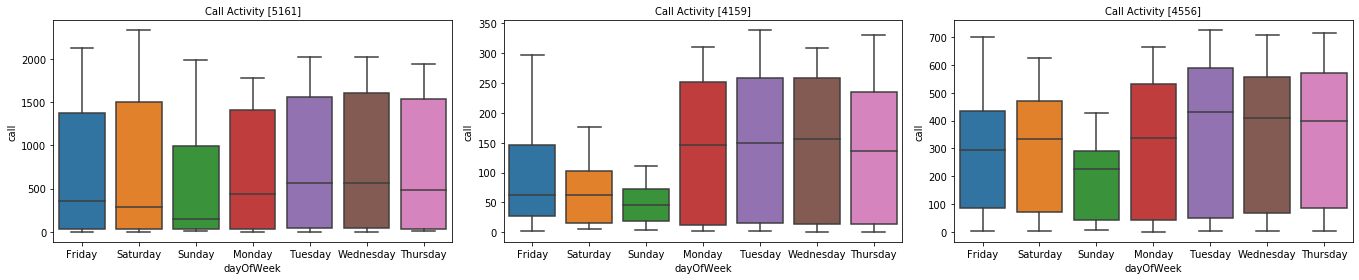

In [42]:
#Plot box plot of SMS activity for each day of the week

fig, ax = plt.subplots(1,3,figsize=(19,4))
ax[0].set_title("Call Activity [5161]")
ax[1].set_title("Call Activity [4159]")
ax[2].set_title("Call Activity [4556]")

sns.boxplot(hourly5161_intr['dayOfWeek'], hourly5161_intr['call'], ax=ax[0])
sns.boxplot(hourly4159_intr['dayOfWeek'], hourly4159_intr['call'], ax=ax[1])
sns.boxplot(hourly4556_intr['dayOfWeek'], hourly4556_intr['call'], ax=ax[2])
fig.tight_layout()
plt.savefig('sav_images/call_daily.svg',transparent=True)
plt.show()

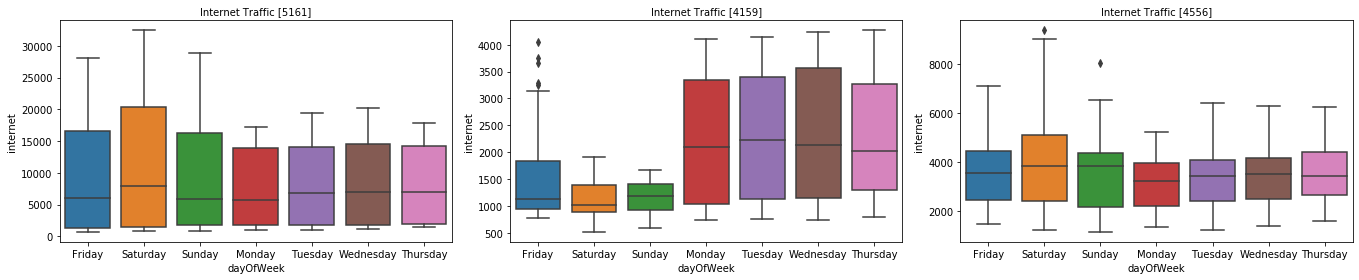

In [43]:
#Plot box plot of SMS activity for each day of the week

fig, ax = plt.subplots(1,3,figsize=(19,4))
ax[0].set_title("Internet Traffic [5161]")
ax[1].set_title("Internet Traffic [4159]")
ax[2].set_title("Internet Traffic [4556]")

sns.boxplot(hourly5161_intr['dayOfWeek'], hourly5161_intr['internet'], ax=ax[0])
sns.boxplot(hourly4159_intr['dayOfWeek'], hourly4159_intr['internet'], ax=ax[1])
sns.boxplot(hourly4556_intr['dayOfWeek'], hourly4556_intr['internet'], ax=ax[2])
fig.tight_layout()
plt.savefig('sav_images/internet_daily.svg',transparent=True)
plt.show()